In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error

In [18]:
df = pd.read_csv('./datasets/cleaned_data/model_data.csv')

In [19]:
df.head(2)

,cond,age,color,breed,target
0,1,senior,black,dachshund,1
1,0,senior,tan,chihuahua,0


# Logistic Regression

In [42]:
X = df[['cond', 'age', 'breed']]

y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, stratify=y)


In [43]:
y.value_counts(normalize=True)

1    0.540995
0    0.459005
Name: target, dtype: float64

In [44]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipe = make_pipeline(ct, LogisticRegression(max_iter=10_000))

In [45]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__onehotencoder', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'lo

In [46]:
params = {
    'logisticregression__C': [.1, 1],
}

gs_logreg = GridSearchCV(pipe, params)
gs_logreg.fit(X_train, y_train)
gs_logreg.best_params_

{'logisticregression__C': 0.1}

In [47]:
preds = gs_logreg.predict(X_test)

print('Train Accuracy: ', gs_logreg.score(X_train, y_train))
print(' Test Accuracy: ', gs_logreg.score(X_test, y_test))

Train Accuracy:  0.624324635015519
 Test Accuracy:  0.6168965517241379


Testing scores were better than the baseline. More models will be tested to compare performance

In [48]:
coefs = gs_logreg.best_estimator_.named_steps['logisticregression'].coef_.squeeze()
cols = gs_logreg.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
pd.DataFrame(zip(cols, coefs)).sort_values(1)

,0,1
119,cond,-1.082851
3,age_young,-0.472296
92,breed_pug,-0.451340
55,breed_fox terrier,-0.289178
47,breed_doberman pinscher,-0.276925
...,...,...
89,breed_plott hound,0.514778
33,breed_bulldog,0.526058
40,breed_chinese shar pei,0.539016
10,breed_american pit bull terrier,0.705561


Breed appears to be a strong predictor in determining if a dog is at risk

# Linear Regression

In [32]:
df_full = pd.read_csv('./datasets/working_data/model_data_full.csv')

In [49]:
X = df_full[
    [
        "pure",
        "obey",
        "reps_lower",
        "reps_upper",
        "height_low_inches",
        "height_high_inches",
        "weight_low_lbs",
        "weight_high_lbs",
    ]
]

y = df_full['time_in_shelter']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [50]:
# avg time in shelter (days)
y.mean()

37.321924303819294

In [51]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'polynomialfeatures', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [52]:
params = {
    'polynomialfeatures__degree': [2, 3],
    'polynomialfeatures__interaction_only': [True, False]
}

gs_linreg = GridSearchCV(pipe, params)
gs_linreg.fit(X_train, y_train)
gs_linreg.best_params_

{'polynomialfeatures__degree': 2, 'polynomialfeatures__interaction_only': True}

In [53]:
preds = gs_linreg.predict(X_test)

print('Train R2: ', gs_linreg.score(X_train, y_train))
print(' Test R2: ', gs_linreg.score(X_test, y_test))
print('    RMSE: ', mean_squared_error(y_test, preds, squared=False))

Train R2:  0.02610403786558102
 Test R2:  0.023545198047840166
    RMSE:  35.96151740577172


Very poor scores. Regression was dropped early on for classification

In [54]:
coefs = gs_linreg.best_estimator_.named_steps['linearregression'].coef_
cols = X_test.columns
pd.DataFrame(zip(cols, coefs)).sort_values(1)

,0,1
4,height_low_inches,-1.844803e+01
2,reps_lower,-7.884083e+00
6,weight_low_lbs,-4.992245e+00
5,height_high_inches,-4.230977e+00
1,obey,-2.789202e-01
0,pure,7.203916e-15
3,reps_upper,9.228019e+00
7,weight_high_lbs,1.017233e+01


# SVM

In [55]:
X = df.drop(columns='color')
X = pd.get_dummies(df).drop(columns=['target'])

y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)

In [56]:
pipe = make_pipeline(LinearSVC())
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'linearsvc', 'linearsvc__C', 'linearsvc__class_weight', 'linearsvc__dual', 'linearsvc__fit_intercept', 'linearsvc__intercept_scaling', 'linearsvc__loss', 'linearsvc__max_iter', 'linearsvc__multi_class', 'linearsvc__penalty', 'linearsvc__random_state', 'linearsvc__tol', 'linearsvc__verbose'])

In [57]:
params = {
    'linearsvc__max_iter': [10_000],
    'linearsvc__random_state': [123],
    'linearsvc__class_weight': ['balanced'],
    'linearsvc__C': np.linspace(.75, 1.25, 20),
    # 'linearsvc__kernel': ['linear', 'rbf', 'polynomial', 'sigmoid']
}

gs_svc = GridSearchCV(pipe, params)
gs_svc.fit(X_train, y_train)
gs_svc.best_params_

{'linearsvc__C': 1.1710526315789473,
 'linearsvc__class_weight': 'balanced',
 'linearsvc__max_iter': 10000,
 'linearsvc__random_state': 123}

In [58]:
preds = gs_svc.predict(X_test)

print('Train Accuracy: ', gs_svc.score(X_train, y_train))
print(' Test Accuracy: ', gs_svc.score(X_test, y_test))

Train Accuracy:  0.6114495919071158
 Test Accuracy:  0.6006896551724138


SVM did worse than logistic regression. Other models will be test to see how they compare

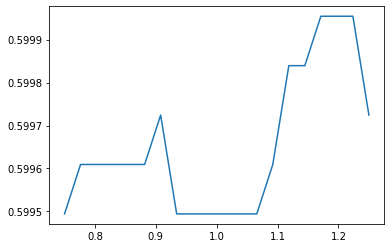

In [59]:
import matplotlib.pyplot as plt

df_plot = pd.DataFrame(gs_svc.cv_results_)

plt.plot('param_linearsvc__C', 'mean_test_score', data=df_plot)

[Run Next](https://github.com/gwoodstock/project4/blob/main/11_predict_petfinder.ipynb): Predict PetFinder API "Unseen" Data